In [ ]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Downsampling path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Upsampling path
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, outputs)
    return model


In [ ]:
def load_and_match_images(clean_images_path, noisy_images_path, img_size=(256, 256)):
    # Get list of image filenames in both directories
    clean_image_files = os.listdir(clean_images_path)
    noisy_image_files = os.listdir(noisy_images_path)

    # Find common filenames (assuming the clean images have the same name pattern as noisy)
    clean_images = []
    noisy_images = []

    for clean_img_file in clean_image_files:
        clean_name, clean_ext = os.path.splitext(clean_img_file)

        # Try to find the corresponding noisy image by matching the name
        for noisy_img_file in noisy_image_files:
            noisy_name, noisy_ext = os.path.splitext(noisy_img_file)
            # If filenames match (except for extensions or possible noise suffix), consider them a pair
            if clean_name in noisy_name:
                # Load the clean image
                clean_img = load_img(os.path.join(clean_images_path, clean_img_file), color_mode='grayscale', target_size=img_size)
                clean_img = img_to_array(clean_img).astype('float32') / 255.0
                clean_images.append(clean_img)

                # Load the noisy image
                noisy_img = load_img(os.path.join(noisy_images_path, noisy_img_file), color_mode='grayscale', target_size=img_size)
                noisy_img = img_to_array(noisy_img).astype('float32') / 255.0
                noisy_images.append(noisy_img)
                break  # Once you find a match, break out of the loop

    return np.array(clean_images), np.array(noisy_images)

# Example usage:
clean_images_path = "/content/drive/My Drive/noisypair/Ground_truth"
noisy_images_path = "/content/drive/My Drive/noisypair/Noisy_folder"
clean_images, noisy_images = load_and_match_images(clean_images_path, noisy_images_path)


In [ ]:
# Ensure clean and noisy images are successfully paired and loaded
print(f"Clean images loaded: {len(clean_images)}")
print(f"Noisy images loaded: {len(noisy_images)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(noisy_images, clean_images, test_size=0.1, random_state=42)

print("Training data shape: ", X_train.shape)
print("Testing data shape: ", X_test.shape)


Clean images loaded: 300
Noisy images loaded: 300
Training data shape:  (270, 256, 256, 1)
Testing data shape:  (30, 256, 256, 1)


In [ ]:
# Create U-Net model
model = unet(input_size=(256, 256, 1))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_split=0.1)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.0140 - loss: 0.7916 - val_accuracy: 0.0079 - val_loss: 0.6401
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 874ms/step - accuracy: 0.0167 - loss: 0.6699 - val_accuracy: 0.0078 - val_loss: 0.5598
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 881ms/step - accuracy: 0.0213 - loss: 0.5586 - val_accuracy: 0.0079 - val_loss: 0.5322
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 874ms/step - accuracy: 0.0186 - loss: 0.5465 - val_accuracy: 0.0079 - val_loss: 0.5406
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 868ms/step - accuracy: 0.0225 - loss: 0.5460 - val_accuracy: 0.0079 - val_loss: 0.5305
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 874ms/step - accuracy: 0.0168 - loss: 0.5397 - val_accuracy: 0.0079 - val_loss: 0.5265
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 872ms/step - accuracy: 0.0253 - loss: 0.5276 - val_accuracy: 0.0079 - val_loss: 0.5250
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 880ms/step - accuracy: 0.0232 - loss: 0.5331 - val

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Displaying results for test image 1/30


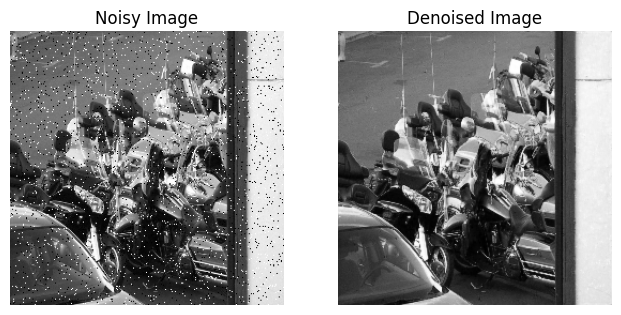

Displaying results for test image 2/30


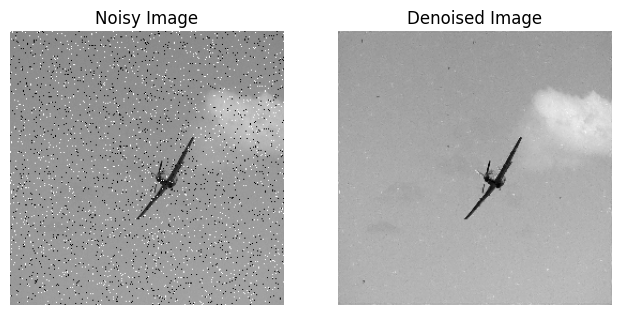

Displaying results for test image 3/30


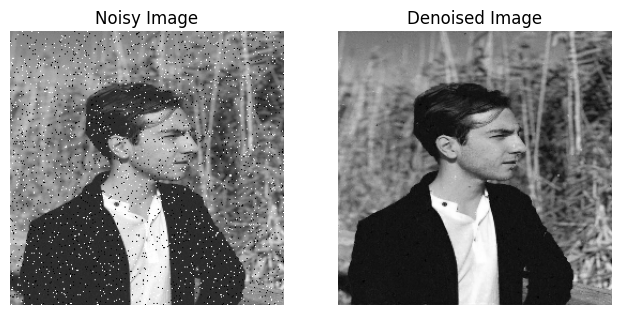

Displaying results for test image 4/30


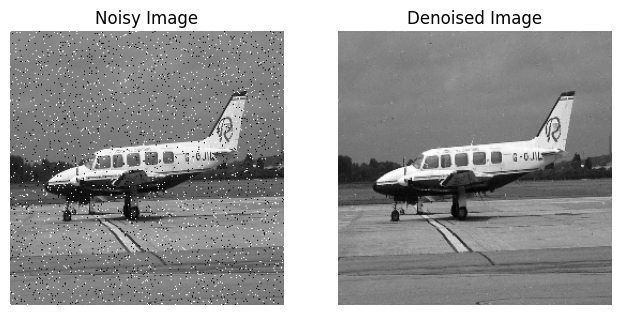

Displaying results for test image 5/30


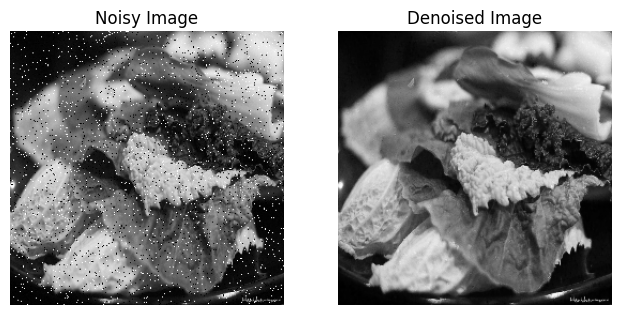

Displaying results for test image 6/30


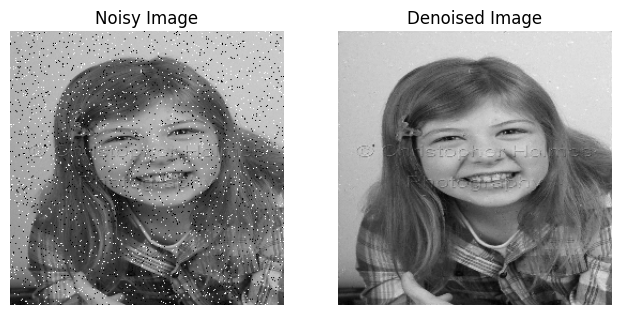

Displaying results for test image 7/30


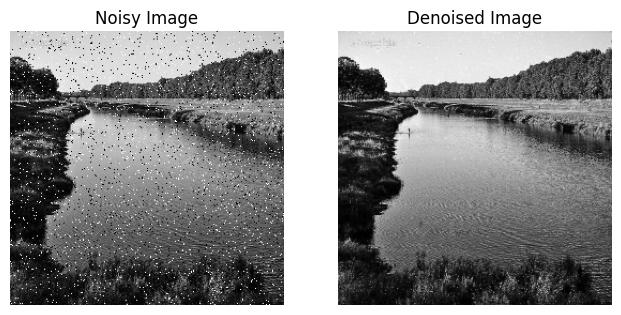

Displaying results for test image 8/30


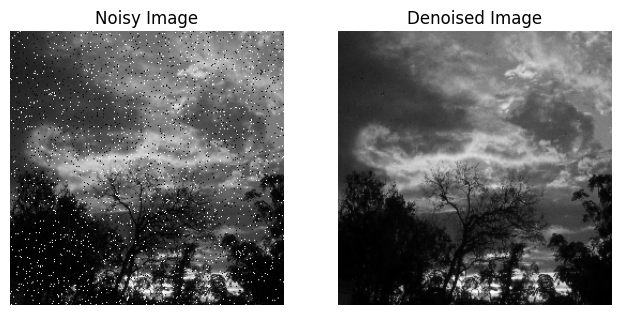

Displaying results for test image 9/30


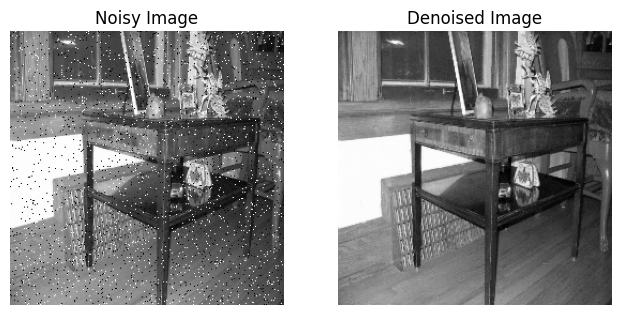

Displaying results for test image 10/30


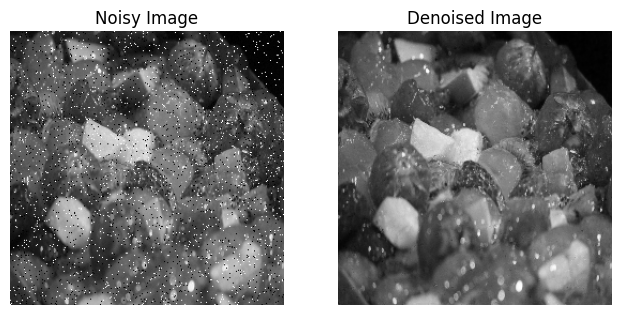

Displaying results for test image 11/30


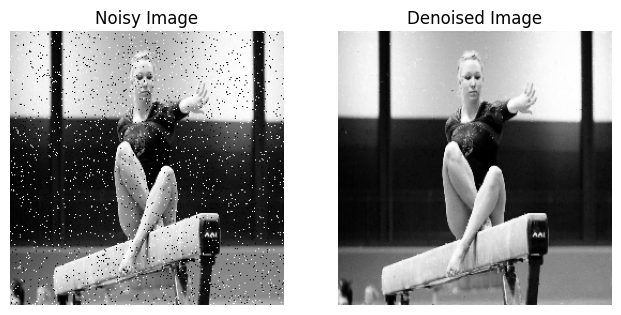

Displaying results for test image 12/30


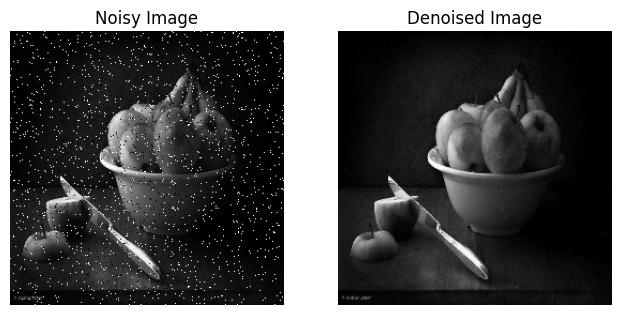

Displaying results for test image 13/30


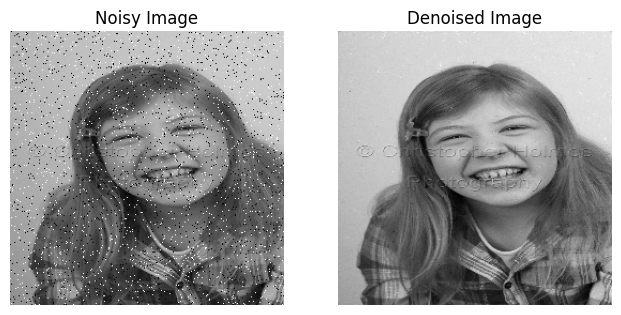

Displaying results for test image 14/30


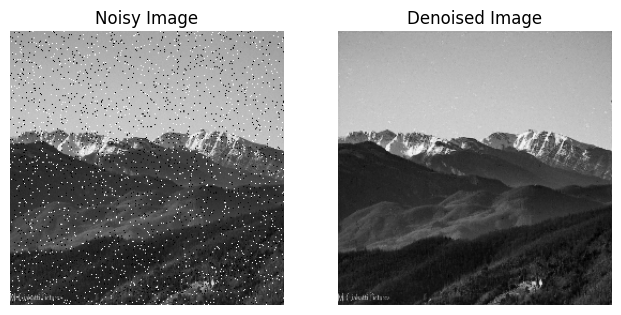

Displaying results for test image 15/30


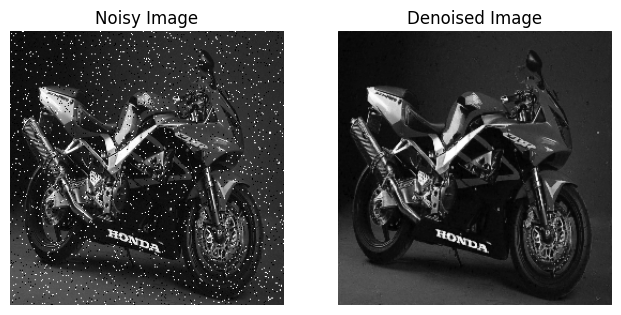

Displaying results for test image 16/30


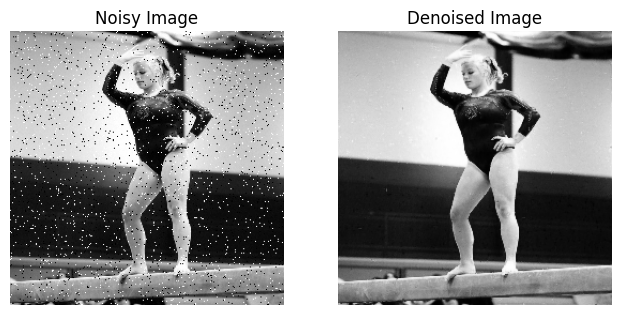

Displaying results for test image 17/30


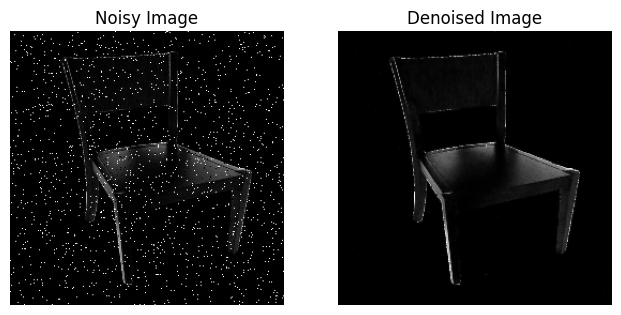

Displaying results for test image 18/30


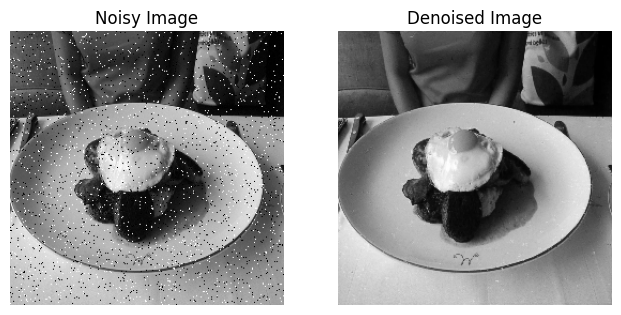

Displaying results for test image 19/30


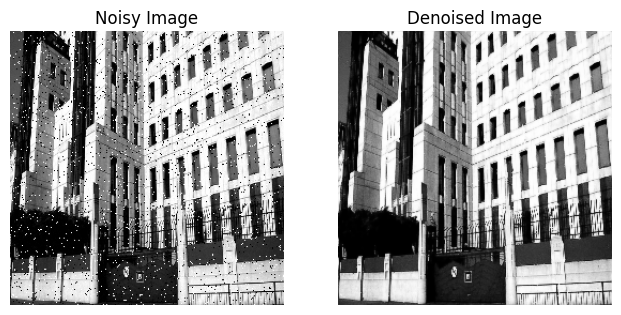

Displaying results for test image 20/30


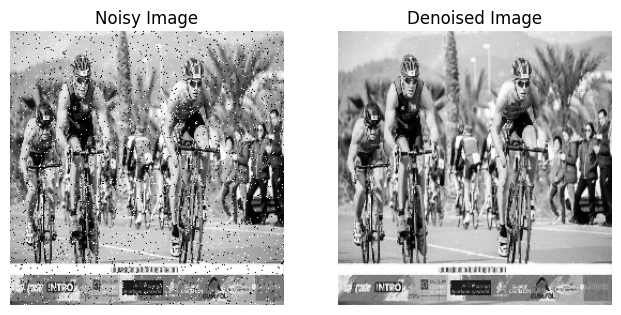

Displaying results for test image 21/30


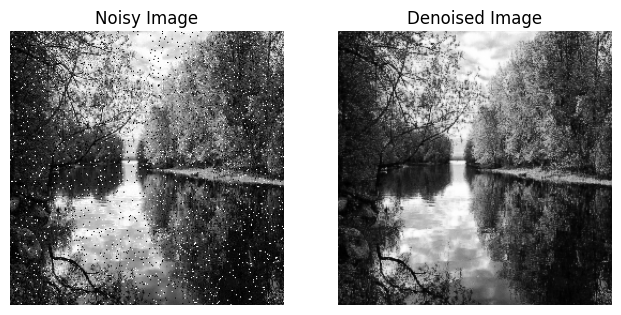

Displaying results for test image 22/30


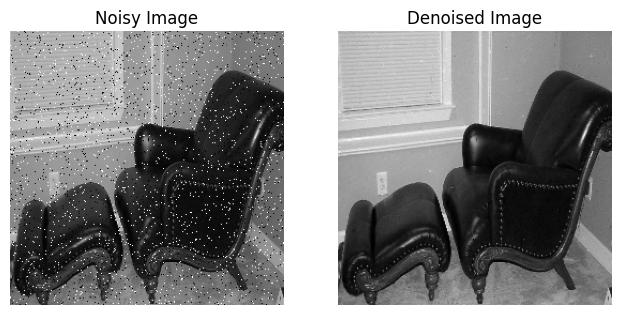

Displaying results for test image 23/30


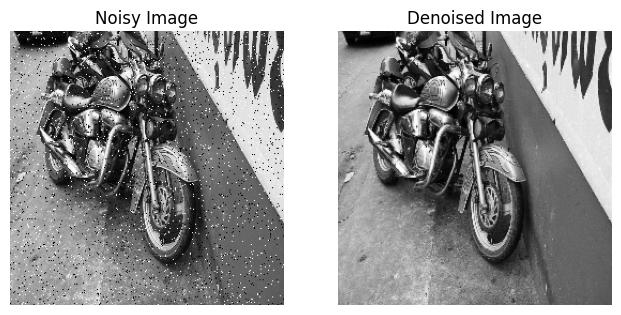

Displaying results for test image 24/30


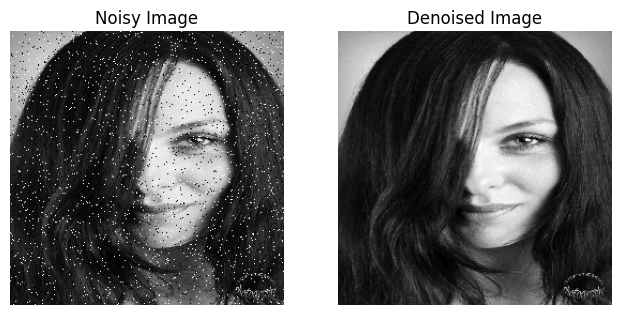

Displaying results for test image 25/30


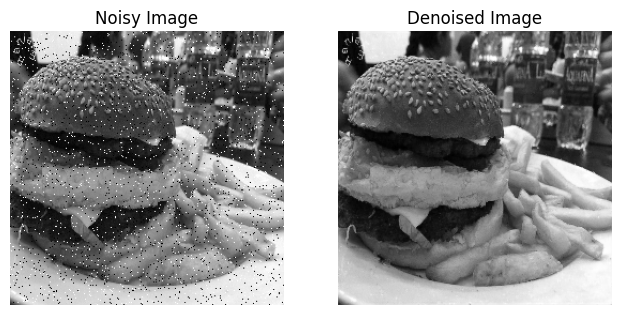

Displaying results for test image 26/30


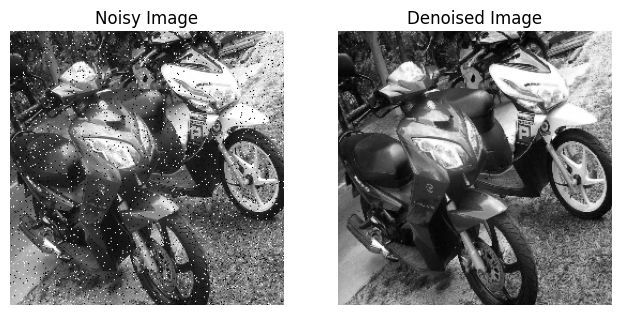

Displaying results for test image 27/30


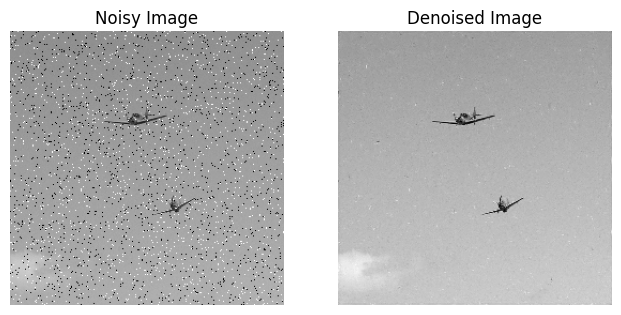

Displaying results for test image 28/30


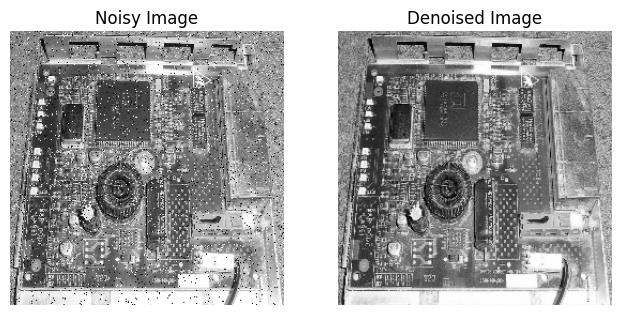

Displaying results for test image 29/30


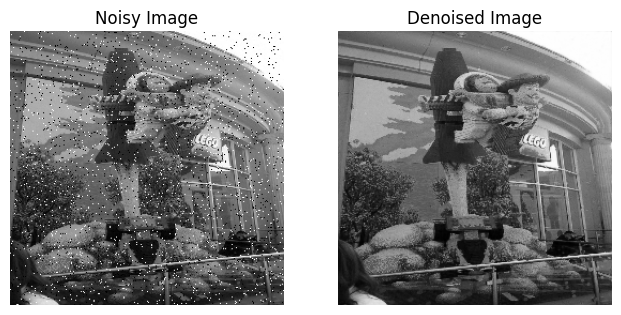

Displaying results for test image 30/30


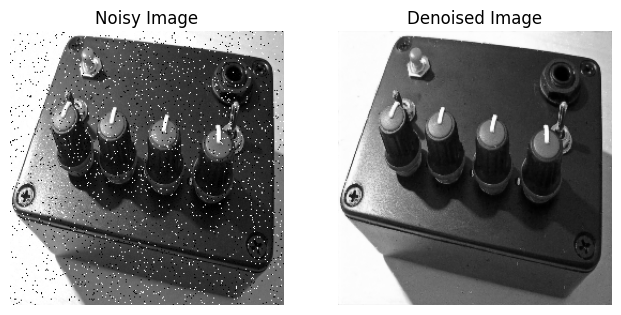

In [ ]:
# Predict on all test data
predicted_images = model.predict(X_test)

# Loop through all the test samples
for sample_idx in range(len(X_test)):
    print(f"Displaying results for test image {sample_idx + 1}/{len(X_test)}")
    # display_results(X_test[sample_idx], predicted_images[sample_idx], y_test[sample_idx]) # This line is commented out as display_results function is not defined in the user's code.

    # Get noisy image for the current sample
    noisy_img = X_test[sample_idx]
    predicted_img = predicted_images[sample_idx]

    # Create a larger figure
    plt.figure(figsize=(12, 4))

    # Noisy image
    plt.subplot(1, 3, 1)
    plt.title("Noisy Image")
    plt.imshow(noisy_img.reshape(256, 256), cmap='gray')
    plt.axis('off')

    # Predicted denoised image
    plt.subplot(1, 3, 2)
    plt.title("Denoised Image")
    plt.imshow(predicted_img.reshape(256, 256), cmap='gray')
    plt.axis('off')

    plt.show()